In [1]:
# Run preprocessing script to make dataframe objects available.

%run PreProcessing.ipynb

Current Progress: 100.0 %
The old training dataframe shape: (2932, 44)
Total number of outliers identified is:  147
The new training dataframe shape: (2785, 44)


In [2]:
# Import required libraries.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from dtreeviz.trees import dtreeviz
from mlxtend.evaluate import bias_variance_decomp
from sklearn.pipeline import Pipeline

In [3]:
# Hypertuning model to find best parameters.
# Print the best qualitative parameters to use within the model.

param_grid = {'random_state': [1],
              'max_features': ['sqrt', 'auto', 'log2'],
              'bootstrap': [True, False]}  
   
grid_rfr = GridSearchCV(RandomForestRegressor(), param_grid, refit = True, verbose = 3, n_jobs= 2)

grid_rfr.fit(X_train, y_train) 
 
print(f'Best Parameters = {grid_rfr.best_params_}')   

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'bootstrap': True, 'max_features': 'auto', 'random_state': 1}


In [4]:
# Fit semi-hypertuned model and print score.

rfr = Pipeline([('rfr', RandomForestRegressor(bootstrap = True, max_features = 'auto', random_state = 1))])

rfr.fit(X_train, y_train)
print(f'Accuracy = {rfr.score(X_test, y_test):.2f}')

Accuracy = 0.94


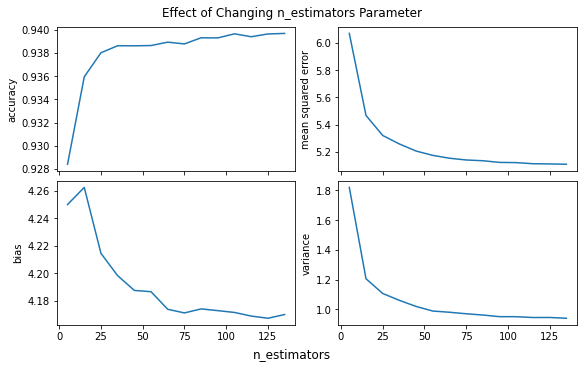

In [5]:
# Optimisation of n_estimators parameter.

hypertune_eval('n_estimators', 5, 145, 10, rfr)

In [6]:
# Set parameter to optimum.

rfr[-1].set_params(n_estimators = 75)
rfr.fit(X_train, y_train)
print(f'Accuracy = {rfr.score(X_test, y_test):.2f}')

Accuracy = 0.94


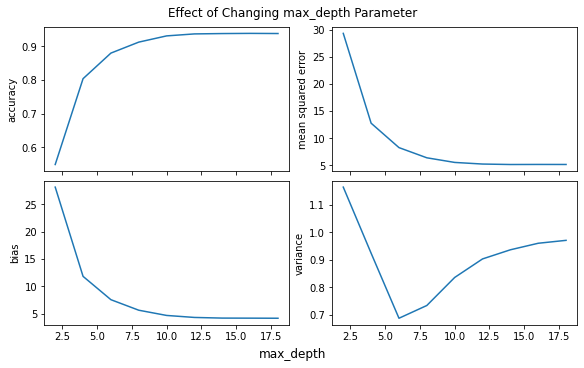

In [7]:
# Optimisation for max_depth parameter.

hypertune_eval('max_depth', 2, 20, 2, rfr)

In [8]:
# Set parameter to optimum and retest score.

rfr[-1].set_params(max_depth = 12)
rfr.fit(X_train, y_train)
print(f'Accuracy = {rfr.score(X_test, y_test):.2f}')

Accuracy = 0.94


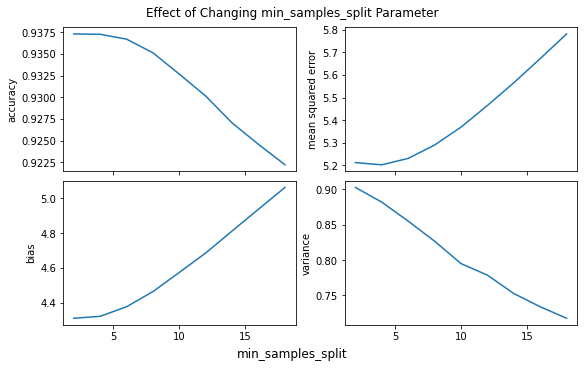

In [9]:
# Optimisation for min_samples_split parameter.

hypertune_eval('min_samples_split', 2, 20, 2, rfr)

In [10]:
# Set parameter to optimum and retest score.

rfr[-1].set_params(min_samples_split = 5)
rfr.fit(X_train, y_train)
print(f'Accuracy = {rfr.score(X_test, y_test):.2f}')

Accuracy = 0.94


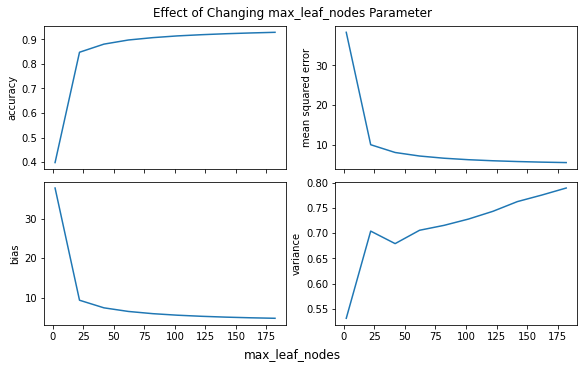

In [11]:
# Optimisation for max_leaf_nodes parameter.

hypertune_eval('max_leaf_nodes', 2, 202, 20, rfr)

In [12]:
# Set parameter to optimum and retest score.

rfr[-1].set_params(max_leaf_nodes = 200)
rfr.fit(X_train, y_train)
print(f'Accuracy = {rfr.score(X_test, y_test):.2f}')

mse_decomp, bias_decomp, var_decomp = bias_variance_decomp(rfr, X_train.values, y_train.values, X_test.values, y_test.values, loss= 'mse', num_rounds = 30, random_seed = 1)

print(f'Mean Error = {mse_decomp**0.5:.2f}')
print(f'Bias = {bias_decomp:.2f}')
print(f'Variance = {var_decomp:.2f}')

rfr_pred = rfr.predict(X_test)

Accuracy = 0.93
Mean Error = 2.34
Bias = 4.63
Variance = 0.84


In [13]:
# Join 'X' and 'y' test df together along with predictions to make visualisations easier.
# Please note... only the test data.

y_test_df = y_test.to_frame()
y_test_df = y_test_df.rename(columns = {0:'mean_diameter'}).reset_index(drop=True)

pred_df = pd.DataFrame(rfr_pred, columns = ['predicted_mean_diameter']).reset_index(drop=True)

X_test_df = pd.DataFrame(X_test, columns = list(X_test)).reset_index(drop = True)

test_df = X_test_df.copy()
test_df['predicted_mean_diameter'] = pd.Series(pred_df['predicted_mean_diameter'])
test_df['mean_diameter'] = pd.Series(y_test_df['mean_diameter'])

test_df = trns.inverse_transform(test_df)
test_df.head()

,pp2m2,heat_units,solar_radiation,organic_matter,predicted_mean_diameter,mean_diameter,method,variety,inputs,protection
0,35,858,555803,2.5,14.291361,10.829714,Bare Roots,Chiefton,Conventional,None
1,37,1627,1329865,18.3,14.531209,15.167568,Drilled,Batter,Conventional,Barley
2,38,2495,1604512,2.8,28.952795,31.715789,Drilled,Chiefton,Conventional,None
3,46,1236,1336335,30.1,12.596193,12.820000,Drilled,Krypton,Conventional,Barley
4,33,1102,668715,2.6,14.590627,19.543030,Plant Tape,Chiefton,Conventional,None


In [14]:
test_df.shape

(734, 10)

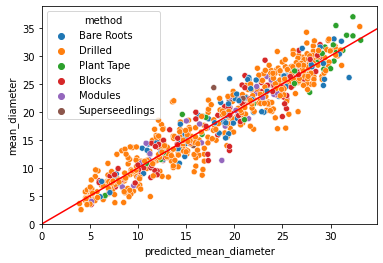

In [15]:
# Scatterplot to show how predicted mean compares to actual mean.
# Set hue to see if any indicator variables have a bias.

sns.scatterplot(y = 'mean_diameter', x = 'predicted_mean_diameter', data = test_df, hue='method')
plt.axline([0, 0], [1, 1], color = 'r')
plt.ylim(0)
plt.xlim(0)
plt.show()

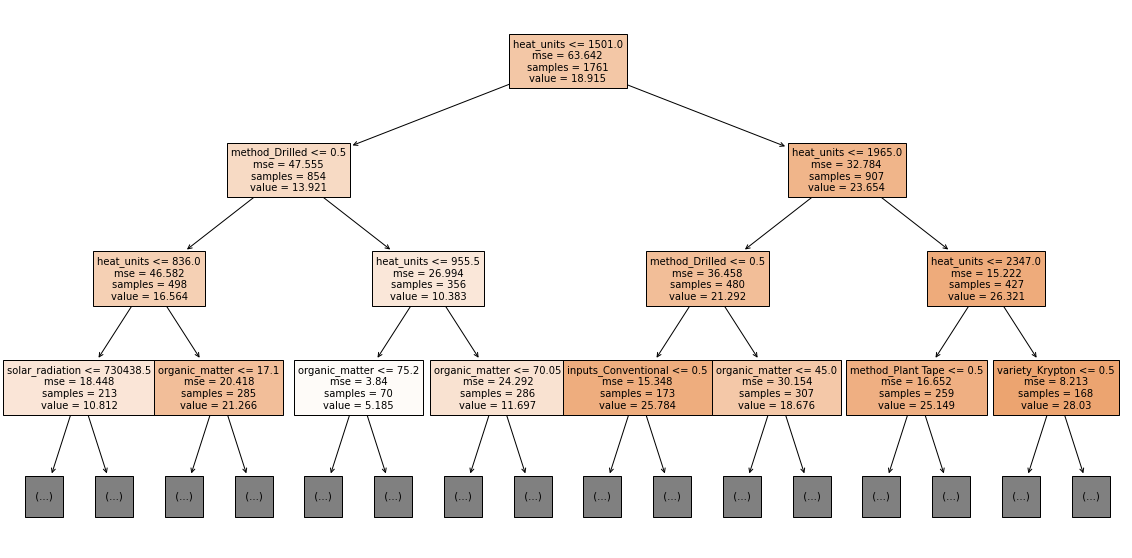

In [16]:
# Tree visualisation to depth of 3.
# Struggling to make visualisation go any deeper.

plt.figure(figsize=(20,10))
tree.plot_tree(rfr[-1].estimators_[0], feature_names=X_train.columns, filled=True, max_depth = 3, fontsize=10)
plt.savefig('Decision Tree.png', dpi=300, bbox_inches = 'tight')
plt.show()

Text(0.5, 0, 'Feature Importance')

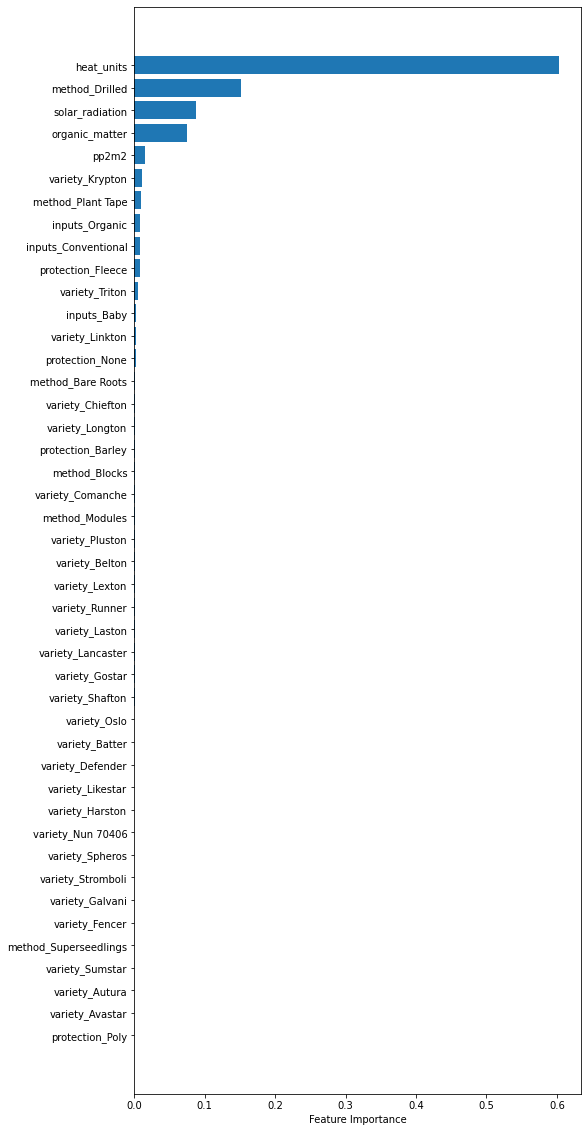

In [17]:
plt.rcParams["figure.figsize"] = (8,20)
sort = rfr[-1].feature_importances_.argsort()
plt.barh(np.array(X_test.columns)[sort], rfr[-1].feature_importances_[sort])
plt.xlabel("Feature Importance")